In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

np.random.seed(2021)

data_loc = '/Users/simon/Documents/DTU/9. semester/deep learning/data'

df_all = []

files = os.listdir(os.path.join(data_loc,'modified data'))
for file in sorted(files):
    path = os.path.join(data_loc,'modified data',file)
    name, ext = os.path.splitext(file)
    if ext != '.csv':
        continue
    df = pd.read_csv(path)
    df.name = name
    
    for col_name in df.columns:
        if col_name != 'Date_Time':
            df[col_name]=df[col_name].astype('float64')
        else:
            df['Date_Time'] = pd.to_datetime(df['Date_Time'])
    
    df_all.append(df)
    print(name)

case=1

display(df_all[case-1].describe().T)
display(df_all[case+2].describe().T)

y = torch.Tensor(df_all[case-1]['Park Power [KW]'].values[:,None])
y_time = df_all[case-1]['Date_Time']
print(df_all[case+2].columns)
x = torch.Tensor(df_all[case+2].iloc[:,1:-4].values)
x_time = df_all[case+2]['Date_Time']

print(x.shape)
print(y.shape)

del df_all
del df

Measurement 1
Measurement 2
Measurement 3
NWP 1
NWP 2
NWP 3


,count,mean,std,min,25%,50%,75%,max
Speed_10m,144711.0,3.031363,3.623477,0.0,0.067,1.500,5.000,15.067
Direction_10m,146730.0,197.287962,79.243239,0.0,170.000,217.400,246.000,360.000
Speed_30m,145380.0,6.418912,3.702942,0.0,3.633,5.633,8.567,18.233
Direction_30m,146730.0,201.393653,79.225843,0.0,167.800,230.000,248.600,360.000
Speed_65m,146019.0,5.365838,4.588243,0.0,0.767,4.867,8.433,19.567
Direction_65m,146730.0,203.584827,83.881323,0.0,163.600,226.300,254.900,360.000
Speed_70m,145778.0,6.938770,4.041043,0.0,3.933,6.400,9.433,19.567
Direction_70m,146730.0,188.332053,75.969289,0.0,149.900,203.000,225.700,360.000
Park Power [KW],142392.0,14847.258624,15060.398944,-314.0,1830.000,9441.000,24913.500,49896.000


,count,mean,std,min,25%,50%,75%,max
Pressure_seaLevel,181504.0,3.124363e-14,1.000000,-3.015335,-0.744509,-1.540506e-02,7.622668e-01,2.836453
Speed_50m,180181.0,-3.231722e-14,1.000000,-2.002099,-0.772936,-2.142258e-01,6.271265e-01,3.184049
Speed_100m,181263.0,-2.293283e-14,1.000000,-2.124329,-0.779369,-1.946571e-02,7.236251e-01,3.043682
Air Density_150m,181670.0,1.238253e-13,1.000000,-1.893695,-0.894750,-1.387915e-01,8.871518e-01,2.682553
Speed_50m_cubed,180181.0,-4.633862e-14,1.000000,-0.687559,-0.601140,-4.216137e-01,1.582373e-01,5.803520
Speed_50m_power_curve,182918.0,4.539636e-13,1.000000,-0.439069,-0.439069,-4.390693e-01,-1.485282e-01,6.467777
Speed_100m_cubed,181263.0,-3.069314e-14,1.000000,-0.849002,-0.715942,-3.523254e-01,3.661931e-01,6.298844
Speed_100m_power_curve,182918.0,5.595524e-13,1.000000,-0.930754,-0.878723,-4.639574e-01,8.659996e-01,2.216261
Direction_50m_cos,181670.0,-2.056168e-01,0.557689,-1.000000,-0.656059,-2.079117e-01,5.233596e-02,1.000000
Direction_50m_sin,181670.0,-4.263490e-01,0.681862,-1.000000,-0.981627,-8.090170e-01,3.489950e-02,1.000000


Index(['Date_Time', 'Pressure_seaLevel', 'Speed_50m', 'Speed_100m',
       'Air Density_150m', 'Speed_50m_cubed', 'Speed_50m_power_curve',
       'Speed_100m_cubed', 'Speed_100m_power_curve', 'Direction_50m_cos',
       'Direction_50m_sin', 'Direction_100m_cos', 'Direction_100m_sin',
       'season_cos', 'season_sin', 'time_day_cos', 'time_day_sin'],
      dtype='object')
torch.Size([182918, 12])
torch.Size([147205, 1])


In [2]:
# make sure all time differences are equal
assert x_time.diff().min()==x_time.diff().max()
assert y_time.diff().min()==y_time.diff().max()
assert x_time.diff().min()==y_time.diff().min()
# check that training and target data end at the same time
assert y_time.iloc[-1]==x_time.iloc[-1]

# Time difference between start of training and target data, and corresponding offset in indecies
time_dif = (y_time.iloc[0]-x_time.iloc[0])
idx_offset = time_dif.days*24*4+round(time_dif.seconds/(60*15))

# Index offset between start and end of training data for one single prediction
# i.e. number of quarters of an hour we wish to train on for each sample
idx_train_len = 3*4+1
subset_to_remove = 0

#i=1000
#print(target_time[i])
#print(x_time[i+idx_offset-idx_train_len+1:i+idx_offset+1])


good_idx = []
for i in range(y.shape[0]):
    if not (torch.isnan(y[i]) or torch.any(torch.isnan(x[i+idx_offset-idx_train_len+1:i+idx_offset+1]))):
        good_idx.append(i)
good_idx = np.array(good_idx)


"""
x_flat = []
x_time_flat = []
y_new = []
y_time_new = []
for i in range(len(y)-subset_to_remove):
    if not (np.isnan(y[i]) or torch.any(torch.isnan(x[i+idx_offset-idx_train_len+1:i+idx_offset+1]))):
        x_flat.append(x[i+idx_offset-idx_train_len+1:i+idx_offset+1].flatten())
        x_time_flat.append(x_time[i+idx_offset-idx_train_len+1:i+idx_offset+1])
        y_new.append(y[i])
        y_time_new.append(y_time[i])
        
        print(x_time[i+idx_offset-idx_train_len+1:i+idx_offset+1])
        print(y_time[i])
        assert False

y = torch.stack(y_new)
y_time = y_time_new
x = torch.stack(x_flat)
x_time = x_time_flat

del x_flat
del y_new
"""

'\nx_flat = []\nx_time_flat = []\ny_new = []\ny_time_new = []\nfor i in range(len(y)-subset_to_remove):\n    if not (np.isnan(y[i]) or torch.any(torch.isnan(x[i+idx_offset-idx_train_len+1:i+idx_offset+1]))):\n        x_flat.append(x[i+idx_offset-idx_train_len+1:i+idx_offset+1].flatten())\n        x_time_flat.append(x_time[i+idx_offset-idx_train_len+1:i+idx_offset+1])\n        y_new.append(y[i])\n        y_time_new.append(y_time[i])\n        \n        print(x_time[i+idx_offset-idx_train_len+1:i+idx_offset+1])\n        print(y_time[i])\n        assert False\n\ny = torch.stack(y_new)\ny_time = y_time_new\nx = torch.stack(x_flat)\nx_time = x_time_flat\n\ndel x_flat\ndel y_new\n'

In [3]:
print(x.shape)
print(y.shape)
print(len(x_time))
print(len(y_time))
print(x_time[0])
print(y_time[0])

torch.Size([182918, 12])
torch.Size([147205, 1])
182918
147205
2016-01-01 20:00:00
2017-01-07 20:15:00


In [4]:
input_size = x.shape[1] * idx_train_len
hidden_size = 50
out_size = 1


# define network
class Net(nn.Module):

    def __init__(self, input_size, hidden_size, out_size):
        super(Net, self).__init__()  
        
        self.model = nn.Sequential(
            nn.Linear(in_features=input_size,
                      out_features=hidden_size,
                      bias=True),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size,
                      out_features=out_size,
                      bias=False)
        )
        
        


    def forward(self, x):
        x = self.model(x)
        return x


net = Net(input_size, hidden_size, out_size)
print(net)

optimizer = optim.Adam(net.parameters())
loss = nn.MSELoss()

Net(
  (model): Sequential(
    (0): Linear(in_features=156, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=1, bias=False)
  )
)


In [9]:
# setting hyperparameters and gettings epoch sizes
batch_size = 10000
num_epochs = 10

num_good = len(good_idx)
np.random.shuffle(good_idx)
k_fold_size = 5

in_valid_bool = np.zeros(num_good, dtype=bool)
in_train_bool = np.zeros(num_good, dtype=bool)


def get_k_fold_cv_idx(k):
    in_valid_bool.fill(0)
    in_valid_bool[k*y.shape[0]//k_fold_size : (k+1)*y.shape[0]//k_fold_size] = 1
    in_train_bool = np.logical_not(in_valid_bool)
    valid_idx = good_idx[in_valid_bool]
    train_idx = good_idx[in_train_bool]
    return valid_idx, train_idx

def get_slice(batch_idx, batch_size): 
    return range(batch_idx * batch_size, (batch_idx + 1) * batch_size)

def get_x_sequences(idx, x_stacked):
    for i in range(len(idx)):
        x_stacked[i, :] = x[idx[i]+idx_offset-idx_train_len+1:idx[i]+idx_offset+1, :].view(-1)
    x_stacked

fold=0
valid_idx, train_idx = get_k_fold_cv_idx(fold)

num_samples_train = train_idx.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = valid_idx.shape[0]
num_batches_valid = num_samples_valid // batch_size

x_input = torch.zeros(batch_size, input_size)

# setting up lists for handling loss/accuracy
train_rmse = []
valid_rmse = []
cur_loss = 0

for epoch in range(num_epochs):
    ## Training
    # Forward -> Backprob -> Update params
    net.train()
    cur_loss = 0
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        
        get_x_sequences(train_idx[slce], x_input)
        
        output = net(x_input)
        
        # compute gradients given loss
        batch_loss = loss(output, y[train_idx][slce])
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    train_rmse.append(np.sqrt(cur_loss.detach().numpy() / num_batches_train))

    ## Validation
    net.eval()
    cur_loss = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        get_x_sequences(valid_idx[slce], x_input)
        output = net(x_input)
        print(output)
        batch_loss = loss(output, y[valid_idx[slce]])
        cur_loss += batch_loss   
    valid_rmse.append(np.sqrt(cur_loss.detach().numpy() / num_batches_valid))
        

    
    if epoch % (num_epochs//10) == 0:
        print("Epoch %2i : Train RMSE %f , Valid RMSE %f" % (
                epoch, train_rmse[-1], valid_rmse[-1]))

        

tensor([[47.6050],
        [ 0.1292],
        [ 4.5192],
        ...,
        [ 3.6861],
        [49.2012],
        [ 2.3601]], grad_fn=<MmBackward>)
tensor([[ 3.8898],
        [ 2.4599],
        [35.3074],
        ...,
        [ 4.8903],
        [ 4.9055],
        [ 4.9737]], grad_fn=<MmBackward>)
Epoch  0 : Train RMSE 20748.778779 , Valid RMSE 20968.051889
tensor([[56.8646],
        [ 0.2331],
        [ 5.8063],
        ...,
        [ 4.6251],
        [59.0837],
        [ 3.0356]], grad_fn=<MmBackward>)
tensor([[ 4.9688],
        [ 3.1746],
        [42.3726],
        ...,
        [ 5.9102],
        [ 6.2526],
        [ 6.3338]], grad_fn=<MmBackward>)
Epoch  1 : Train RMSE 20741.701685 , Valid RMSE 20960.407630
tensor([[67.0402],
        [ 0.3174],
        [ 7.3860],
        ...,
        [ 5.8143],
        [69.9508],
        [ 3.8089]], grad_fn=<MmBackward>)
tensor([[ 6.2798],
        [ 4.0690],
        [50.1533],
        ...,
        [ 7.3228],
        [ 7.9156],
        [ 8.0189]], 

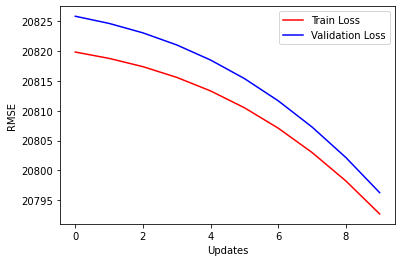

In [7]:
epoch = np.arange(len(train_rmse))
plt.figure()
plt.plot(epoch, train_rmse, 'r', epoch, valid_rmse, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('RMSE')
plt.show()

In [10]:
y[good_idx]

tensor([[ 2.4266e+04],
        [ 5.5060e+03],
        [ 6.4400e+02],
        ...,
        [ 7.9000e+02],
        [ 1.2352e+04],
        [-1.0000e+00]])